In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase, gc, gwylmo_cpclean
from numpy.linalg import norm
from scipy.optimize import curve_fit,minimize,fmin

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=not True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv3-cp-bounded-dev
(notebook)>> We are not on the expected branch. This may cause unexpected behavior.


In [162]:
# alert(str(gc.lmlist),header=True)
# For all pairs of l and m in the global config file
for ll,mm in [(3,3)]: # gc.lmlist:
    
    #
    alert('(l,m)=(%i,%i)'%(ll,mm), header=True)

    #
    datadir = '/Users/book/KOALA/PhenomXCP/data/version4/'
    files = glob( datadir+'*_l%im%i.txt'%(ll,mm) )
    files.sort()
    files = files[::-1]

    #
    file_map = []
    for j,sn_ in enumerate(metadata_dict['simname']):
        
        # Find index location of this metadata in the list of file paths
        k = [ k for k,val in enumerate(files) if sn_ in val ][0]

        # 
        file_map.append(k)
        

    # Sort file paths like matadata so that we can then sort both according to distance between physical parameters
    files = array(files)[file_map]
        
    reference_index = 0
    # theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
    mask = [0,3,9] # theta, eta, a1 -- the parameters that will be used to calculate distance for sorting
    coordinates = metadata_dict['array_data'][:,mask]
    coordinates[:,0] = cos(coordinates[:,0]) # use cos theta 
    index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=not False )

    #
    files = list(files[index_map])
    
    #
    if ll==3:
        files = [ f for f in files if 'q1' not in f  ]
        
        
    reverse_index_map = argsort( index_map ).astype(int) # array([ int(c) for c in argsort( index_map ) ]),dtype=int

    # Get number of parameters to be tuned
    scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
    var_count = scarecrow.__code__.co_argcount - 1

    # #
    # fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 2.0*1 ]) )
    # ax = ax.flatten()
    # 
    # #
    # tight_layout(pad=1,w_pad=4,h_pad=4)

    #
    foo = {}

    #
    lmlist = [ (ll,mm) ]

    #
    p = 0
    popt_array  = zeros( (len(files),var_count) )
    fit_obj_list = []
    physical_param_array = zeros( (len(files), 17) )
#     alert('Plotting ...')
    for j,f_ in enumerate(files):
    
        if 'q2a06t120' in f_:#'q8a08t30' in f_:

            #
            simname = f_.split('/')[-1].split('_l%im%i.'%(ll,mm))[0]

            # Find index location of metadata for simname 
            k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

            # Load data for this case
            raw_data = loadtxt(f_).T
            #calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data, simname=simname, lm=(ll,mm) )

            # Collect params for this case 
            metadata = metadata_dict['array_data'][k,:]

            #
            #f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
            theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]
            
            #
            break
            


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> (l,m)=(3,3)
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #



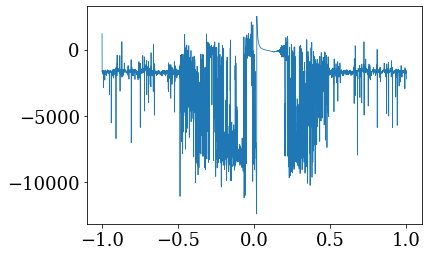

In [163]:
raw_f,raw_amp_fd,raw_dphi_fd,raw_alpha,raw_beta,raw_gamma = raw_data

plot( raw_f, raw_dphi_fd )

0.5 4950 [2969 2722] [-1237.5  1237. ]


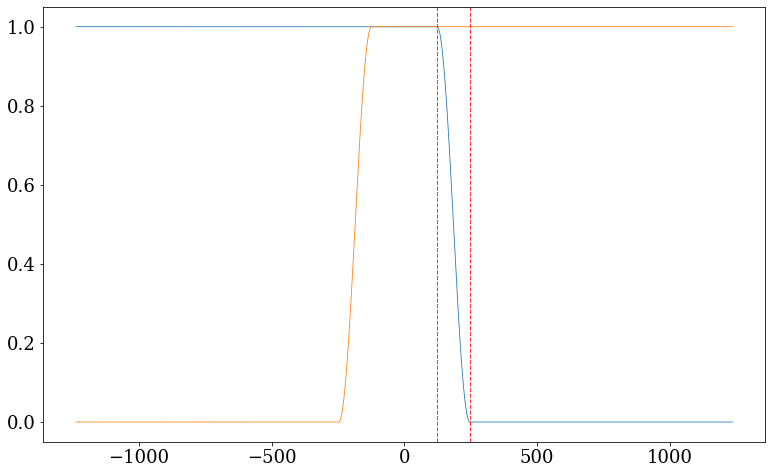

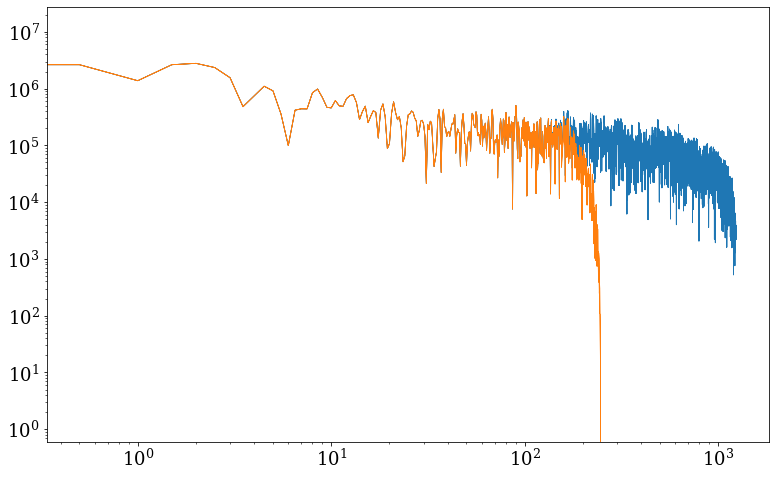

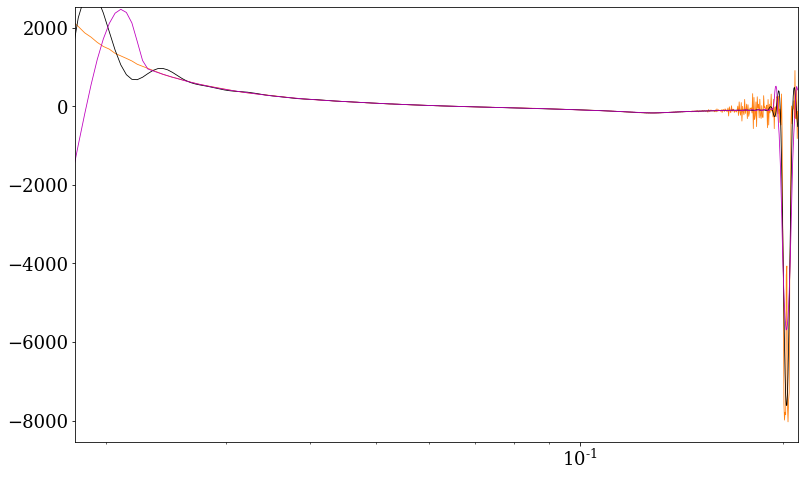

In [164]:
from scipy.fftpack import fft, fftfreq, ifftshift, fftshift, ifft


ff = fftshift(fftfreq( len(raw_f), raw_f[1]-raw_f[0] ))
dff = ff[1]-ff[0]

raw_state = [max(ff)/10,max(ff)/5]
state = array([ int( k/dff + len(ff)*0.5 ) for k in raw_state[::-1] ])
print(dff,len(ff),state,lim(ff))
taper_r = maketaper( ff, state )
taper_l = maketaper( ff, len(ff)-state )
taper = taper_r * taper_l

x = raw_dphi_fd
X = fftshift(fft(x))
Y = taper*X
y = ifft( ifftshift(Y) )

figure( figsize = 2*figaspect(0.618) )
plot( ff,taper_r )
plot( ff,taper_l )
axvline(raw_state[0] ,color='r',ls='--')
axvline(raw_state[1] ,color='r',ls='--')

figure( figsize = 2*figaspect(0.618) )
plot( abs(ff),abs(X) )
plot( abs(ff),abs(Y) )
xscale('log')
yscale('log')

figure( figsize = 2*figaspect(0.618) )
plot( raw_f, x, color='tab:orange')
plot( raw_f, y.real,color='k')
plot( raw_f, smooth(x,width=30).answer,color='m')
xlim(0.012*3*0.5,0.14*3*0.5)
ylim( lim(limy(raw_f, x),dilate=0.05) )
xscale('log')
